In [1]:
from ultralytics import YOLO
import  cv2
import cvzone
import math

cap = cv2.VideoCapture(0)
cap.set(3, 1280)
cap.set(4, 720)

model = YOLO('../YOLO Weights/yolov8n.pt')

classNames = ["outer crochet stitch"]
img = cv2.imread('stitch.jpg')
results = model(img)
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        w, h = x2-x1, y2-y1
        cvzone.cornerRect(img, (x1, y1, w, h))

        conf = math.ceil((box.conf[0]*100))/100

        cls = box.cls[0]
        print(cls)
        name = classNames[int(cls)]

        cvzone.putTextRect(img, f'{name} 'f'{conf}', (max(0,x1), max(35,y1)), scale = 0.5)

cv2.imshow("Image",img)

ModuleNotFoundError: No module named 'ultralytics'

In [7]:
import torch
import clip
import numpy as np
import cv2
from PIL import Image

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "stitch.jpg"
original_image = cv2.imread(image_path)
image = Image.open(image_path)
image_height, image_width, _ = original_image.shape

# Generate region proposals (Selective Search)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(original_image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# Define the target object as a text description
target_object = "outer crochet stitch"  # Replace with your target object
text_tokens = clip.tokenize([target_object]).to(device)

# Iterate through region proposals and classify them
selected_boxes = []
for (x, y, w, h) in rects[:1000]:  # Process top 1000 regions
    # Crop and preprocess the region
    region = original_image[y:y+h, x:x+w]
    if region.size == 0:  # Skip empty regions
        continue
    region_pil = Image.fromarray(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    region_preprocessed = preprocess(region_pil).unsqueeze(0).to(device)

    # Compute similarity with the target text
    with torch.no_grad():
        region_features = model.encode_image(region_preprocessed)
        text_features = model.encode_text(text_tokens)
        similarity = torch.cosine_similarity(region_features, text_features)

    # Keep regions with high similarity
    if similarity.item() > 0.3:  # Adjust threshold as needed
        selected_boxes.append((x, y, x + w, y + h))

# Draw bounding boxes on the original image
for (x1, y1, x2, y2) in selected_boxes:
    cv2.rectangle(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(original_image, target_object, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with bounding boxes
cv2.imshow("Detected Objects", original_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optional: Save the output image
cv2.imwrite("output.jpg", original_image)


AttributeError: module 'cv2' has no attribute 'ximgproc'

In [2]:
import torch
import clip
from PIL import Image, ImageDraw, ImageFont
from transformers import DetrImageProcessor, DetrForObjectDetection
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Load CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Load DETR (object detection model)
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(device)

# Helper to draw bounding boxes
def draw_boxes(image, boxes, labels, scores, color="red"):
    draw = ImageDraw.Draw(image)
    for box, label, score in zip(boxes, labels, scores):
        draw.rectangle(box.tolist(), outline=color, width=3)
        text = f"{label} ({score:.2f})"
        draw.text((box[0], box[1]), text, fill=color)
    return image

# Main function
def detect_and_draw(image_path, text_input):
    # Open and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = detr_processor(images=image, return_tensors="pt").to(device)
    
    # Perform object detection
    outputs = detr_model(**image_tensor)
    logits = outputs.logits[0]
    boxes = outputs.pred_boxes[0].detach().cpu().numpy()
    
    # Filter by confidence threshold
    confidence_threshold = 0.7
    probs = logits.softmax(-1)[:, :-1]  # Exclude "no object" class
    scores, labels = probs.max(dim=1)
    keep = scores > confidence_threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
    
    # Prepare text embeddings
    text = clip.tokenize([text_input]).to(device)
    text_features = clip_model.encode_text(text).detach().cpu()
    
    # Calculate similarity and filter boxes
    matched_boxes, matched_scores = [], []
    for box in boxes:
        # Crop region and preprocess for CLIP
        cropped_region = image.crop(box)
        clip_image = clip_preprocess(cropped_region).unsqueeze(0).to(device)
        
        # Compute similarity
        image_features = clip_model.encode_image(clip_image).detach().cpu()
        similarity = torch.cosine_similarity(image_features, text_features)
        
        # Append high-similarity results
        if similarity.item() > 0.3:
            matched_boxes.append(box)
            matched_scores.append(similarity.item())
    
    # Draw bounding boxes
    final_image = draw_boxes(image, matched_boxes, [text_input] * len(matched_boxes), matched_scores)
    return final_image

# Example usage
if __name__ == "__main__":
    result_image = detect_and_draw("stitch.jpg", "outer crochet stitch")
    result_image.show()  # Display the image with bounding boxes


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

ImportError: 
DetrConvEncoder requires the timm library but it was not found in your environment. You can install it with pip:
`pip install timm`. Please note that you may need to restart your runtime after installation.


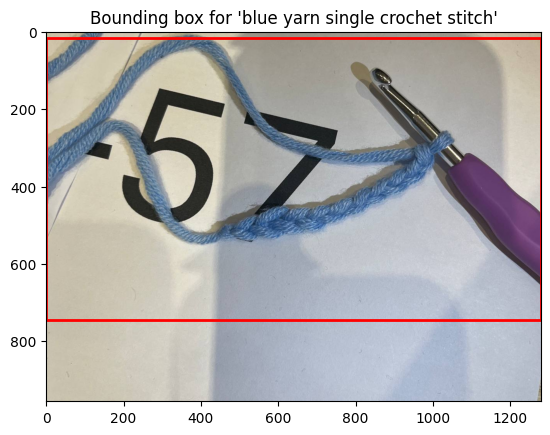

In [6]:
import torch
from transformers import CLIPProcessor, CLIPModel
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the CLIP model and processor
# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# # Load the pre-trained Faster R-CNN model
# detection_model = fasterrcnn_resnet50_fpn(pretrained=True)
# detection_model.eval()

# Function to get bounding box for a given query
def get_bounding_box(image_path, query):
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(text=[query], images=image, return_tensors="pt", padding=True)

    # Get text features from CLIP
    with torch.no_grad():
        text_features = clip_model.get_text_features(input_ids=inputs["input_ids"])

    # Perform object detection
    transform = F.to_tensor(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        detections = detection_model(transform)[0]

    # Find the bounding box with the highest similarity to the query
    max_similarity = float('-inf')
    best_bbox = None

    for i, bbox in enumerate(detections['boxes']):
        # Extract the region of the image corresponding to the bounding box
        xmin, ymin, xmax, ymax = bbox.int().tolist()
        region = image.crop((xmin, ymin, xmax, ymax))

        # Process the region and get its CLIP features
        region_inputs = clip_processor(images=region, return_tensors="pt", padding=True)
        with torch.no_grad():
            region_features = clip_model.get_image_features(pixel_values=region_inputs["pixel_values"])

        # Calculate similarity between the text features and the region features
        similarity = torch.nn.functional.cosine_similarity(text_features, region_features).item()

        if similarity > max_similarity:
            max_similarity = similarity
            best_bbox = bbox

    return best_bbox.int().tolist() if best_bbox is not None else None

# Function to display image with bounding box
def display_image_with_bbox(image_path, bbox, query):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    if bbox is not None:
        xmin, ymin, xmax, ymax = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.title(f"Bounding box for '{query}'")
    else:
        plt.title(f"No bounding box found for '{query}'")
    plt.show()

# Example usage
image_path = "stitch.jpg"
query = "blue yarn single crochet stitch"
bounding_box = get_bounding_box(image_path, query)
display_image_with_bbox(image_path, bounding_box, query)
